# Dual Quaternion interpolation Method for Dual Quaternions

write about the new interpolation method

In [1]:
from neura_dual_quaternions import DualQuaternion, Quaternion
from DualQuaternionQuinticBlends.LineGenerator import LineGenerator
from DualQuaternionQuinticBlends.ArcGenerator import ArcGenerator
from DualQuaternionQuinticBlends.DQQBTrajectoryGenerator import DQQBTrajectoryGenerator

import numpy as np

%matplotlib widget
import matplotlib.animation as animation
import matplotlib.pyplot as plt

In [2]:
rx = np.array([1,0,0])
ry = np.array([0,1,0])
rz = np.array([0,0,1])

dq1 = DualQuaternion.fromQuatPos(Quaternion.fromAxisAngle(np.pi*0.0, rx), np.array([-1,0, 0]))
dq2 = DualQuaternion.fromQuatPos(Quaternion.fromAxisAngle(np.pi*0.5, rx), np.array([0, 0, 0 ]))
dq3 = DualQuaternion.fromQuatPos(Quaternion.fromAxisAngle(np.pi*1.5, ry), np.array([0, 1, 0 ]))
# dq4 = DualQuaternion.fromQuatPos(Quaternion.fromAxisAngle(np.pi*0.3, rx), np.array([0.7,0.8,0.1]))
# dq5 = DualQuaternion.fromQuatPos(Quaternion.fromAxisAngle(np.pi*1.1, rx), np.array([1,0,0.3]))
# dq6 = DualQuaternion.fromQuatPos(Quaternion.fromAxisAngle(np.pi*0.6, rx), np.array([1,-0.5,0]))

DQ_list = [dq1, dq2, dq3]

line_generator = LineGenerator()

segments = line_generator.generateSegments(DQ_list, 0.2, .6)

In [3]:
p1 = np.array([-1,0,0])
p2 = np.array([-0.7, 0.7,0 ])
p3 = np.array([0, 1,0 ])
p4 = np.array([0.7,0.8,0.1])
p5 = np.array([1,0,0.3])
p6 = np.array([1,-0.5,0])

rx = np.array([1,0,0])
ry = np.array([0,1,0])
rz = np.array([0,0,1])

dq1 = DualQuaternion.fromQuatPos(Quaternion.fromAxisAngle(np.pi*0.0, rx), p1)
dq2 = DualQuaternion.fromQuatPos(Quaternion.fromAxisAngle(np.pi*0.0, rx), p2)
dq3 = DualQuaternion.fromQuatPos(Quaternion.fromAxisAngle(np.pi*0.0, ry), p3)
dq4 = DualQuaternion.fromQuatPos(Quaternion.fromAxisAngle(np.pi*1.0, rz), p4)
dq5 = DualQuaternion.fromQuatPos(Quaternion.fromAxisAngle(np.pi*0.3, rx), p5)
dq6 = DualQuaternion.fromQuatPos(Quaternion.fromAxisAngle(np.pi*1.0, ry), p6)

DQ_list = [dq1, dq2, dq3, dq4, dq5, dq6]

arc_generator = ArcGenerator()

segments = arc_generator.generateSegments(DQ_list, 0.2, .6)

In [4]:
trajectory = DQQBTrajectoryGenerator(segments, 10, 100, 5, 150)

cnt:  1
acceleration limit for translational interpolation violated!
acceleration limit for translational interpolation violated!
acceleration limit for orientation interpolation violated!
acceleration limit for translational interpolation violated!
acceleration limit for orientation interpolation violated!
acceleration limit for translational interpolation violated!
acceleration limit for orientation interpolation violated!
cnt:  2
cnt:  3
cnt:  4
cnt:  5
cnt:  6
cnt:  7
cnt:  8
cnt:  9
cnt:  10


In [5]:
time_vec = np.arange(0, trajectory.time_vector[-1]+0.01, 0.01)
qw = []
qx = []
qy = []
qz = []

x = []
y = []
z = []

vel_norm_list = []
acc_norm_list = []
jerk_norm_list = []

ang_vel_norm_list = []
ang_acc_norm_list = []
ang_jerk_norm_list = []

quaternion_list = []

for t in time_vec:
    
    pos, vel, acc, jerk, quaternion, ang_vel, ang_acc, ang_jerk = trajectory.evaluate(t)
    
    vel_norm_list.append(np.linalg.norm(vel))
    acc_norm_list.append(np.linalg.norm(acc))
    jerk_norm_list.append(np.linalg.norm(jerk))
    
    ang_vel_norm_list.append(np.linalg.norm(ang_vel))
    ang_acc_norm_list.append(np.linalg.norm(ang_acc))
    ang_jerk_norm_list.append(np.linalg.norm(ang_jerk))
    
    quaternion_list.append(quaternion)
    
    x.append(pos[0])
    y.append(pos[1])
    z.append(pos[2])
    
    qw.append(quaternion.w)
    qx.append(quaternion.x)
    qy.append(quaternion.y)
    qz.append(quaternion.z)


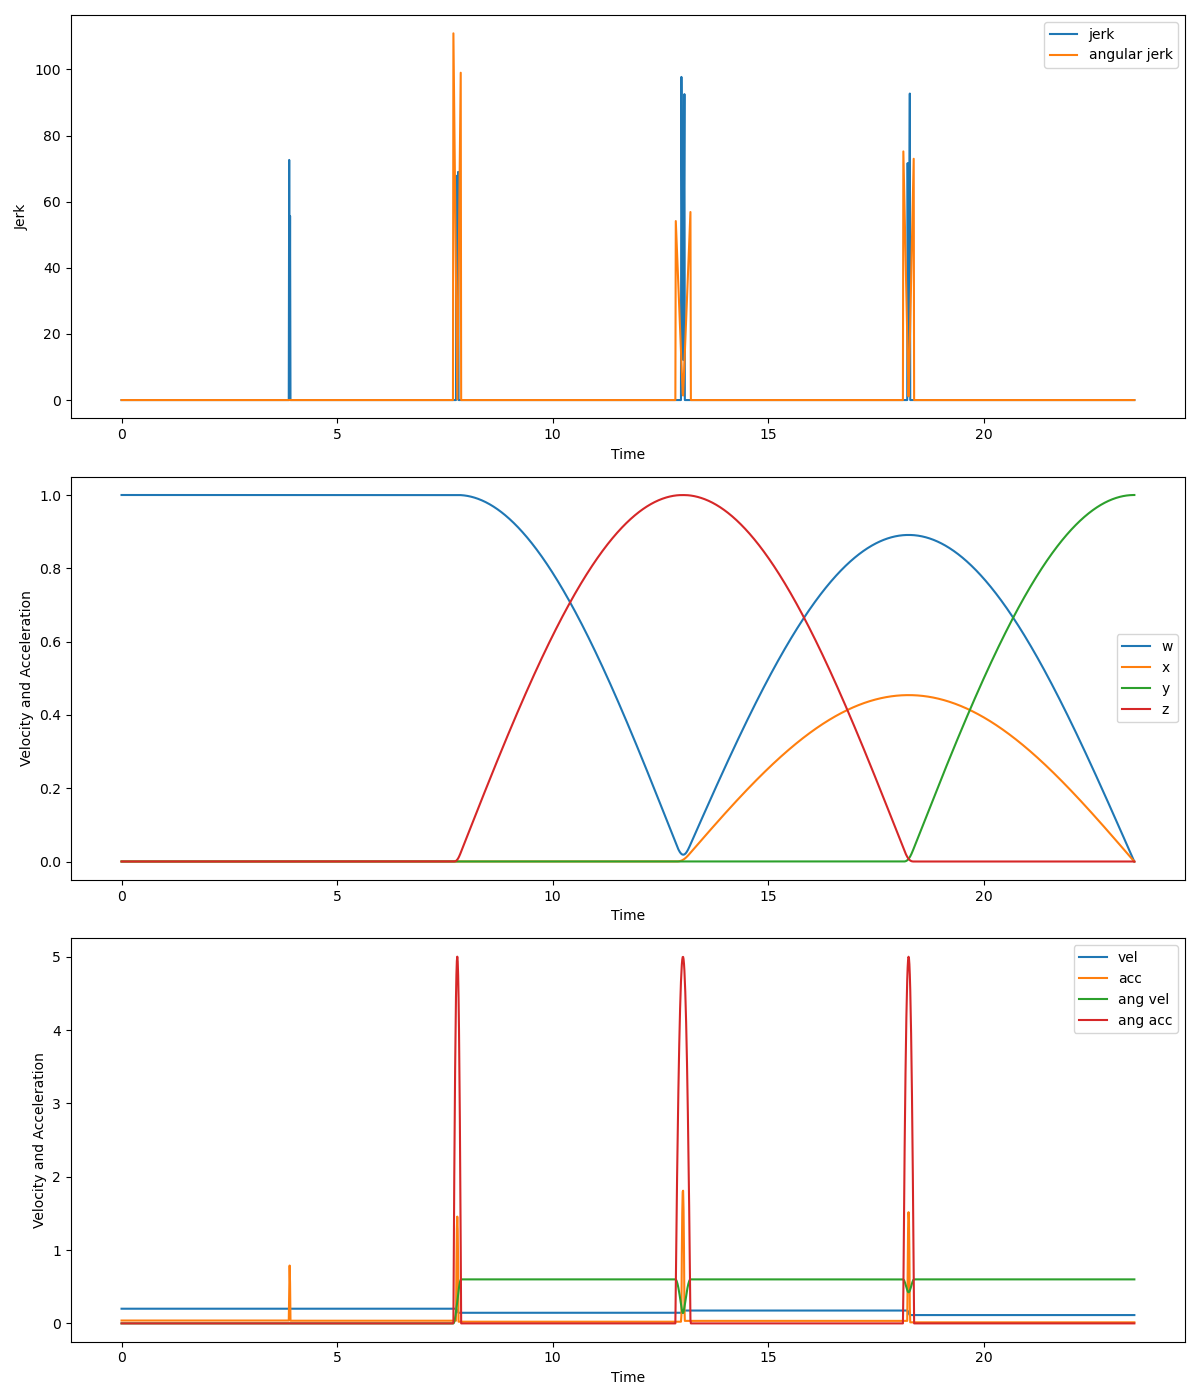

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 14))

# Plot the quaternion values in the first subplot (ax1)
ax1.plot(time_vec, jerk_norm_list, label = "jerk")
ax1.plot(time_vec, ang_jerk_norm_list, label = "angular jerk")
# ax1.plot(time_vec, jerk_norm_list, label = "jerk")
# ax1.plot(time_vec, ang_jerk_norm_list, label = "ang_jerk")
ax1.set_xlabel('Time')
ax1.set_ylabel('Jerk')
ax1.legend()

#ax2.plot(time_vec, vel_norm_list, label = "vel")
#ax2.plot(time_vec, acc_norm_list, label = "acc")

# ax2.plot(time_vec, ang_vel_norm_list, label = "ang vel")
# ax2.plot(time_vec, ang_acc_norm_list, label = "ang acc")
ax2.plot(time_vec, qw, label = "w")
ax2.plot(time_vec, qx, label = "x")
ax2.plot(time_vec, qy, label = "y")
ax2.plot(time_vec, qz, label = "z")

ax2.set_xlabel('Time')
ax2.set_ylabel('Velocity and Acceleration')
ax2.legend()


ax3.plot(time_vec, vel_norm_list, label = "vel")
ax3.plot(time_vec, acc_norm_list, label = "acc")

ax3.plot(time_vec, ang_vel_norm_list, label = "ang vel")
ax3.plot(time_vec, ang_acc_norm_list, label = "ang acc")

ax3.set_xlabel('Time')
ax3.set_ylabel('Velocity and Acceleration')
ax3.legend()

# # Adjust the layout and display the plot
plt.tight_layout()
plt.show()

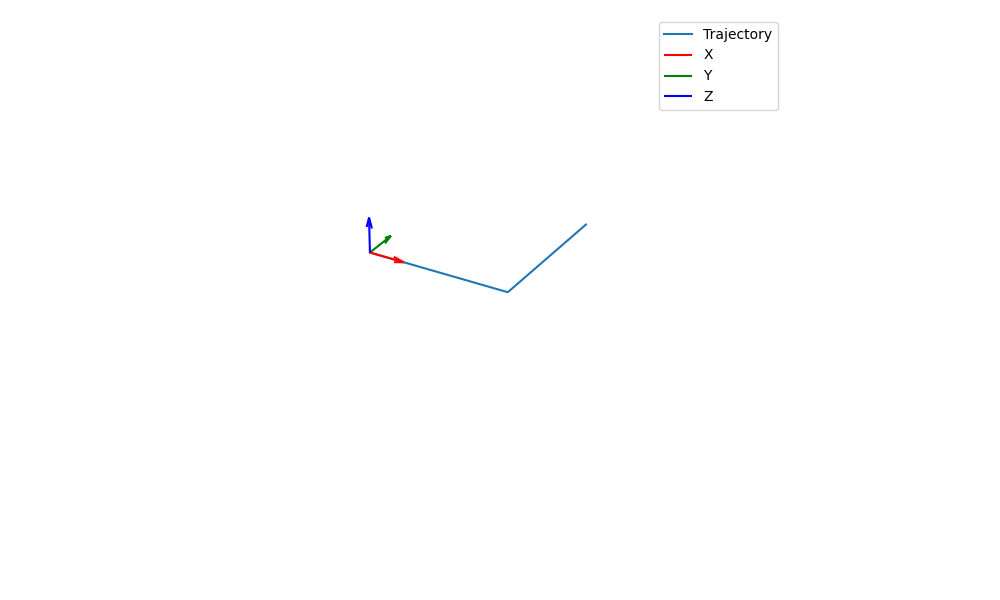

In [8]:
# Create a new figure for the 3D plot
fig_3d = plt.figure(figsize=(10, 6))

# Create 3D axes
ax_3d = fig_3d.add_subplot(111, projection='3d')
fig_3d.canvas.header_visible = False
size = 1
ax_3d.set_xlim([-size, size])
ax_3d.set_ylim([-size, size])
ax_3d.set_zlim([-size, size])
ax_3d.set_box_aspect([1, 1, 1])
plt.tight_layout()
ax_3d.set_facecolor('white')
ax_3d.set_axis_off()

ax_3d.plot(x, y, z, label='Trajectory')
for spine in ax_3d.spines.values():
    spine.set_visible(False)
    


R = np.eye(3)*0.25
rx = ax_3d.quiver(x[0], y[0], z[0], *R[:,0], color='red', label='X')
ry = ax_3d.quiver(x[0], y[0], z[0], *R[:,1], color='green', label='Y')
rz = ax_3d.quiver(x[0], y[0], z[0], *R[:,2], color='blue', label='Z')
ax_3d.legend()

# Define the update function for the animation
def update(frame):

    global rx, ry, rz
    rx.remove()
    ry.remove()
    rz.remove()
    
    R = quaternion_list[frame].asRotationMatrix()*0.25
    rx = ax_3d.quiver(x[frame], y[frame], z[frame], *R[:,0], color='red', label='X')
    ry = ax_3d.quiver(x[frame], y[frame], z[frame], *R[:,1], color='green', label='Y')
    rz = ax_3d.quiver(x[frame], y[frame], z[frame], *R[:,2], color='blue', label='Z')

# Create the FuncAnimation object with a smaller interval for faster animation
ani = animation.FuncAnimation(fig_3d, update, frames=len(x), repeat=False, interval=0)

# Display the animation
plt.show()

## First Derivative of a Dual Quaternion

Given a dual quaternion $\mathbb{DQ} = q_r + \epsilon q_d$, where $q_r$ is the rotation quaternion and $q_d$ is the translation quaternion, and $\epsilon$ is the dual unit with $\epsilon^2 = 0$.

The time derivative of $\mathbb{DQ}$, denoted $\dot{\mathbb{DQ}}$, can be derived considering the rigid body's angular velocity $\boldsymbol{\omega}$ and linear velocity $\mathbf{v}$. These are represented as pure quaternions: $\omega_q = 0 + \boldsymbol{\omega}_x \mathbf{i} + \boldsymbol{\omega}_y \mathbf{j} + \boldsymbol{\omega}_z \mathbf{k}$ and $v_q = 0 + v_x \mathbf{i} + v_y \mathbf{j} + v_z \mathbf{k}$.

The derivative of the rotation part is given by $\frac{1}{2} \omega_q \cdot q_r$. For the translation part, the derivative is $\frac{1}{2} (\omega_q \cdot q_d + v_q \cdot q_r)$. Combining these, we get:

$$
\dot{\mathbb{DQ}} = \frac{1}{2} (\omega_q \cdot q_r + \epsilon(\omega_q \cdot q_d + v_q \cdot q_r))
$$

## Second Derivative of a Dual Quaternion

To derive the second derivative $\ddot{\mathbb{DQ}}$, we consider the angular acceleration $\boldsymbol{\alpha}$ and linear acceleration $\mathbf{a}$, also represented as pure quaternions: $\alpha_q = 0 + \boldsymbol{\alpha}_x \mathbf{i} + \boldsymbol{\alpha}_y \mathbf{j} + \boldsymbol{\alpha}_z \mathbf{k}$ and $a_q = 0 + a_x \mathbf{i} + a_y \mathbf{j} + a_z \mathbf{k}$.

The second derivative involves differentiating the first derivative $\dot{\mathbb{DQ}}$. This is complex due to quaternion multiplication rules. The simplified form is given by:

$$
\ddot{\mathbb{DQ}} = \frac{1}{2} \left( \alpha_q \cdot q_r + \omega_q \cdot \dot{q}_r + \epsilon(\alpha_q \cdot q_d + \omega_q \cdot \dot{q}_d + a_q \cdot q_r + v_q \cdot \dot{q}_r) \right)
$$

Here, $\dot{q}_r$ and $\dot{q}_d$ are the derivatives of the rotation and translation parts of $\mathbb{DQ}$, as computed in $\dot{\mathbb{DQ}}$.


# Computing Velocities from the First Derivative of a Dual Quaternion

Given the first derivative of a dual quaternion $\dot{\mathbb{DQ}} = \dot{q}_r + \epsilon \dot{q}_d$, where $\dot{q}_r$ and $\dot{q}_d$ are the derivatives of the rotation and translation parts of the dual quaternion:

1. **Angular Velocity**:
   
   The angular velocity in quaternion form $\omega_q$ is obtained by:

   $$
   \omega_q = 2 \dot{q}_r q_r^{-1}
   $$

   Here, $q_r^{-1}$ is the inverse of the rotation quaternion. The vector part of $\omega_q$ gives the angular velocity $\boldsymbol{\omega}$.

2. **Linear Velocity**:
   
   Linear velocity in quaternion form $v_q$ is more complex to extract:

   $$
   v_q = 2 (\dot{q}_d - \omega_q q_d) q_r^{-1}
   $$

   The vector part of $v_q$ gives the linear velocity $\mathbf{v}$.

## Computing Accelerations from the Second Derivative of a Dual Quaternion

Given the second derivative of a dual quaternion $\ddot{\mathbb{DQ}} = \ddot{q}_r + \epsilon \ddot{q}_d$:

1. **Angular Acceleration**:
   
   Angular acceleration $\boldsymbol{\alpha}$ is related to the rate of change of $\omega_q$ and $q_r$. This requires solving a system of equations derived from differentiating the angular velocity equation.

2. **Linear Acceleration**:
   
   Linear acceleration $\mathbf{a}$ can be extracted by differentiating the linear velocity equation and solving for $a_q$. This involves quaternion representations of velocity and acceleration and their derivatives.

Note: The extraction of angular and linear accelerations from the second derivative is complex and often application-specific, potentially requiring numerical methods or simplifying assumptions.
